# Exercícios da Aula 12 - Detector de Hough

## Samuel Felipe dos Santos

#### Bibliotecas Usadas

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
import os

#### Funções de Aulas Anteriores

As seguintes funções foram reaproveitadas de aulas anteriores.

In [2]:
#faz com que os pixels da imagem variem entre os valores de  img_min e img_max
def rescale(img, img_min, img_max):
    mn = img.min()
    mx = img.max()
    return ((img-mn)/(mx-mn)*(img_max-img_min) + img_min)

#verifica se um ponto de coordenadas [i,j] é válida para uma imagem de dimensões shape
def valid_point( shape, i,j ):
    if i>=0 and i<shape[0] and j>=0 and j<shape[1]:
        return True
    else:
        return False


## Exercício

- **Implemente um detector de Hough para encontrar células na base de células.**

**1) Use apenas círculos maiores que o tamanho do núcleo, mas que encontrem as células.**

**2) Repita o processo com dois detectores: um para encontrar as membranas das células e outro para os núcleos.
O centro da membrana e de seu núcleo devem estar próximos.**

    - Usar 2 detectores individuais com pesos diferentes.

**3) Tente criar uma única matriz acumulada para dois círculos concêntricos
(membrana e núcleo)**

    - Use um único detector com coordenadas x e y do centro e dois raios diferentes rc e rn para a célula e para o núcleo. (matriz 4D)

- **Faça o exercício 1 e escolha entre o 2 ou 3.**

Abaixo é mostrada a implementação do detector de Hough realizada para encontrar circulos.

É gerado uma representação na imagem  no espaço de $a \times b$, que representam os centros dos circulos, como é dado nas seguintes equações:

$a = x - r\times cos(\theta)$

$b = y - r\times sin(\theta)$

Os valores de $a$ e $b$ são calculados em cada ponto da imagem original, sendo acumulado a quantidade de pontos que teriam como centro essas coodernadas;
$r$ é um valor de raio fixo determinado pelo usuário e $\theta$ é variado de $0^\circ$ a $360^\circ$ convertidos em radianos.

Foi decidido procurar apenas um valor de raio devido ao desempenho computacional do método, no entanto, durante os experimentos, o algoritmo é rodado para varios tamanhos de raio.

In [3]:
def hough_circle_transform( img, radius=5 ):
    angles = np.arange( 0, 360 ) * np.pi / 180
    accumulator = np.zeros( img.shape, dtype='uint')
    
    for x,y in np.argwhere( img ):
        for theta in angles:
            a = int(x-np.round(r*np.cos(theta)))
            b = int(y-np.round(r*np.sin(theta)))
            #print(a,b)
            if valid_point( img.shape, a,b ):
                accumulator[a,b] += 1
    
    return accumulator

Abaixo é mostrada as imagens do conjunto de dados de células usadas nos experimentos. Foram as mesmas imagens dos exercícios da aula anterior, que fez uso do Haar.

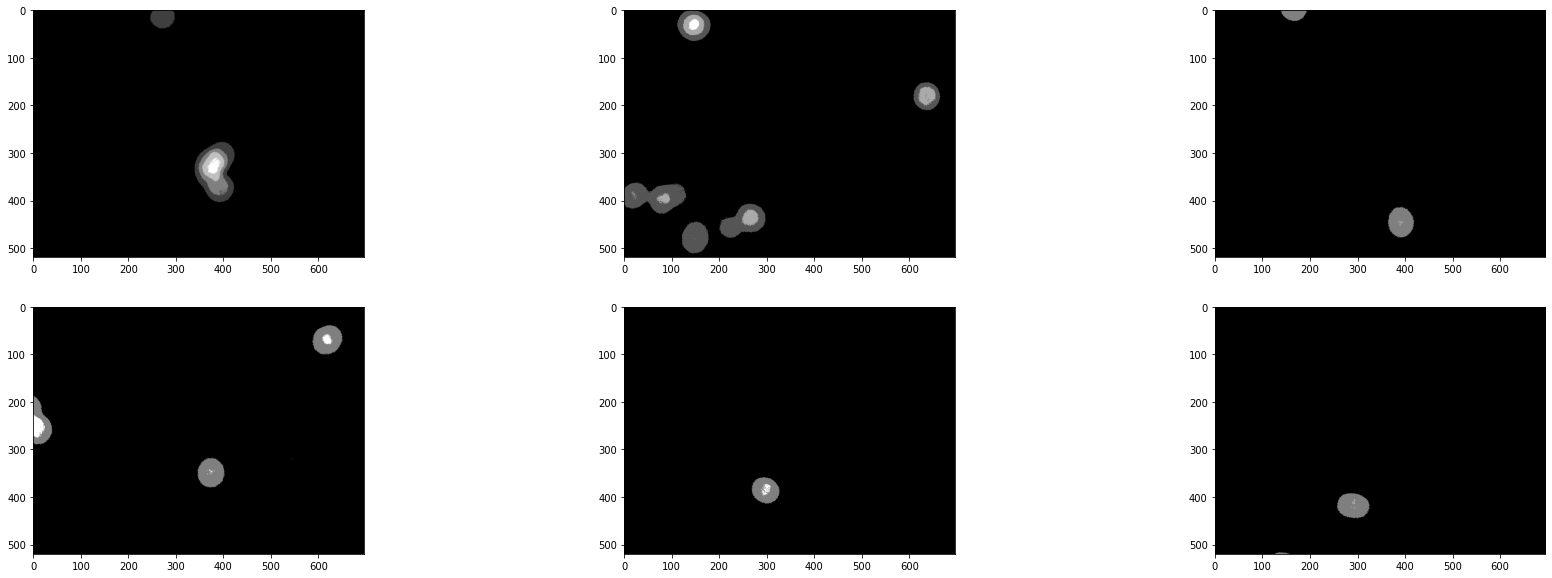

In [4]:
path = 'data/aula11/cells'
files = os.listdir( path )
imgs = []
fig = plt.figure(figsize=(30, 10))

for i,file in enumerate(files):
    img = rescale(cv.imread(os.path.join(path,file), 0), 0,255).astype('uint8')
    imgs += [img]
    fig.add_subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')

Inicialmente foi extraido o contorno das imagen usando o algoritmo de Canny, sendo mostrado os resultados obtidos a seguir.

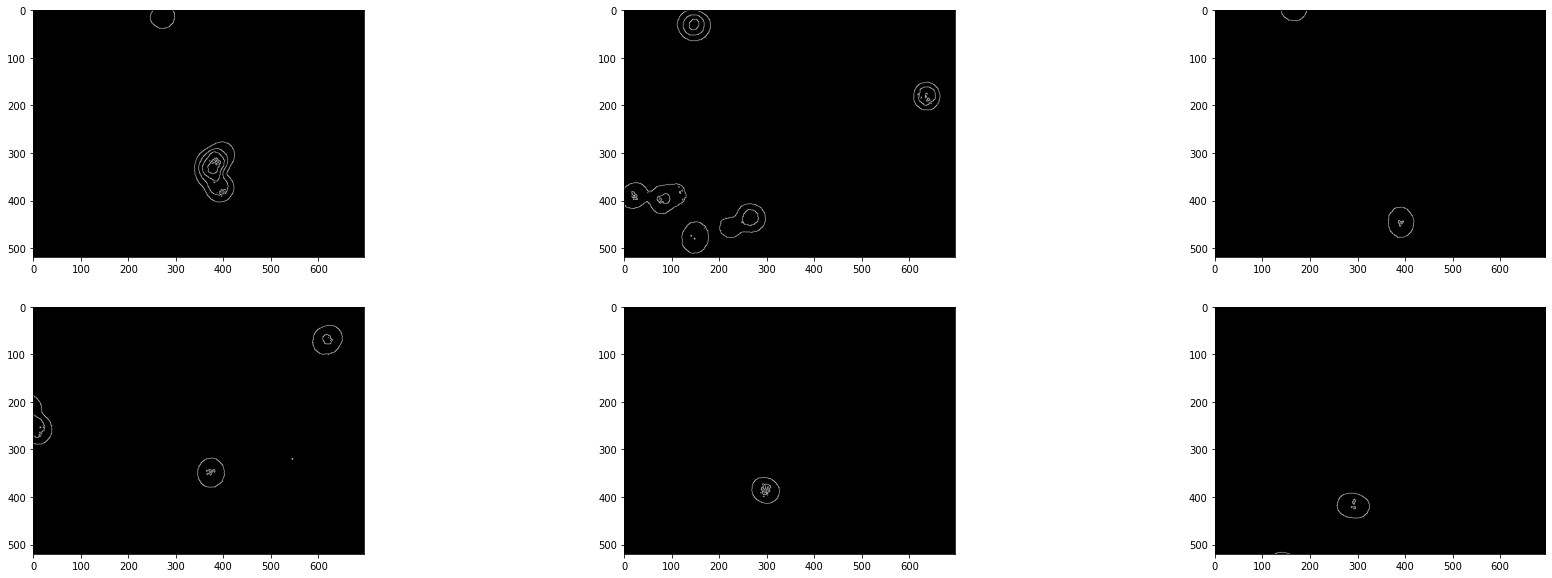

In [5]:
contours = []
fig = plt.figure(figsize=(30, 10))
for i,img in enumerate(imgs):
    c = rescale(cv.Canny(img, 100, 200, True, 7 ), 0,1)
    contours += [c] 
    fig.add_subplot(2, 3, i+1)
    plt.imshow(c, cmap='gray')

As características de Hough são extraidas da imagem, sendo elas o espaço $a \times b$ que indica onde é mais provavel que exista um centro de circulo.

Essas características foram extraidas para $12$ tamanhos de raio diferentes, sendo eles $2,5,8,10,15,20,25,30,35,40,45$ e $50$.

A seguir são mostrados esses resultados, é possivel verificar que em circulos bem definidos, quando o raio é adequado, um ponto central da maior intensidade é gerado, no entanto, quando o circulo não é bem definido ou o valor do raio não é ideal, é gerado um circulo com intensidade alta ao redor do centro que se desejaria encontrar.

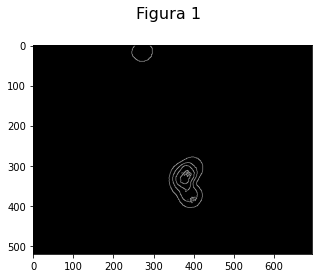

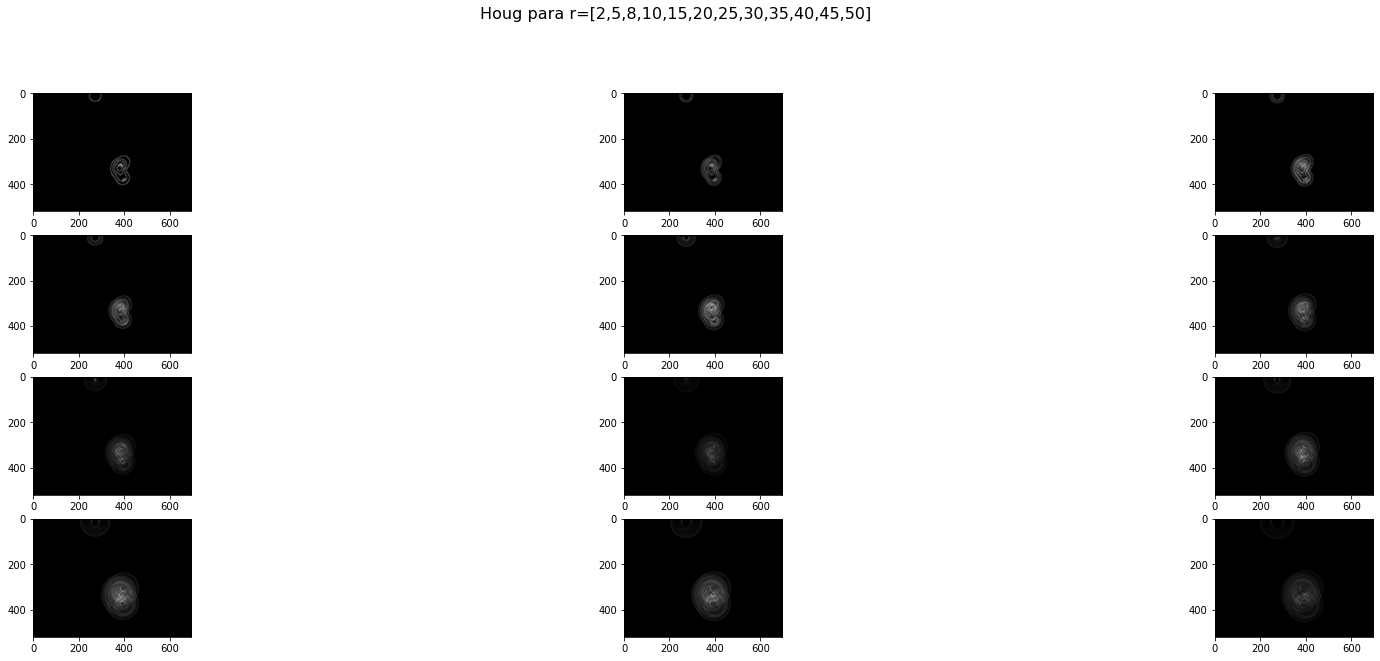

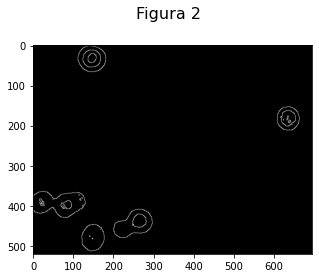

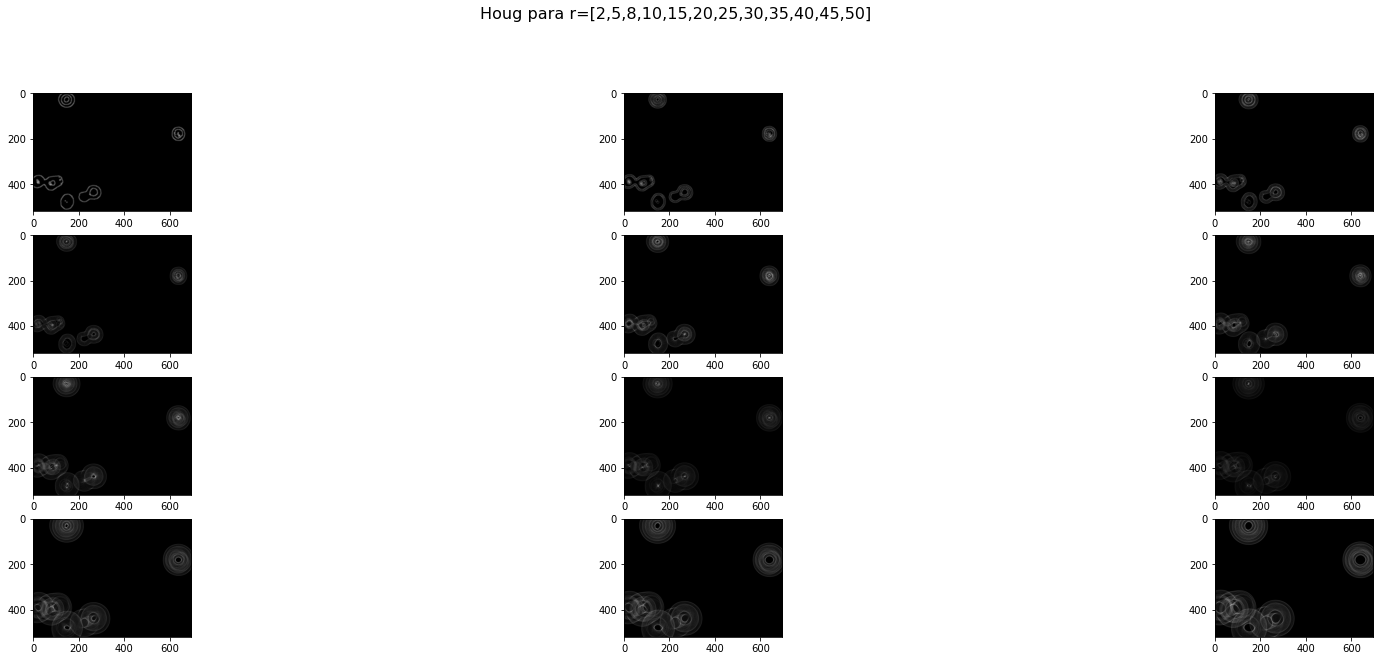

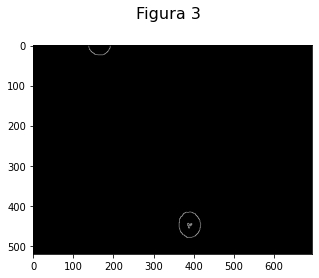

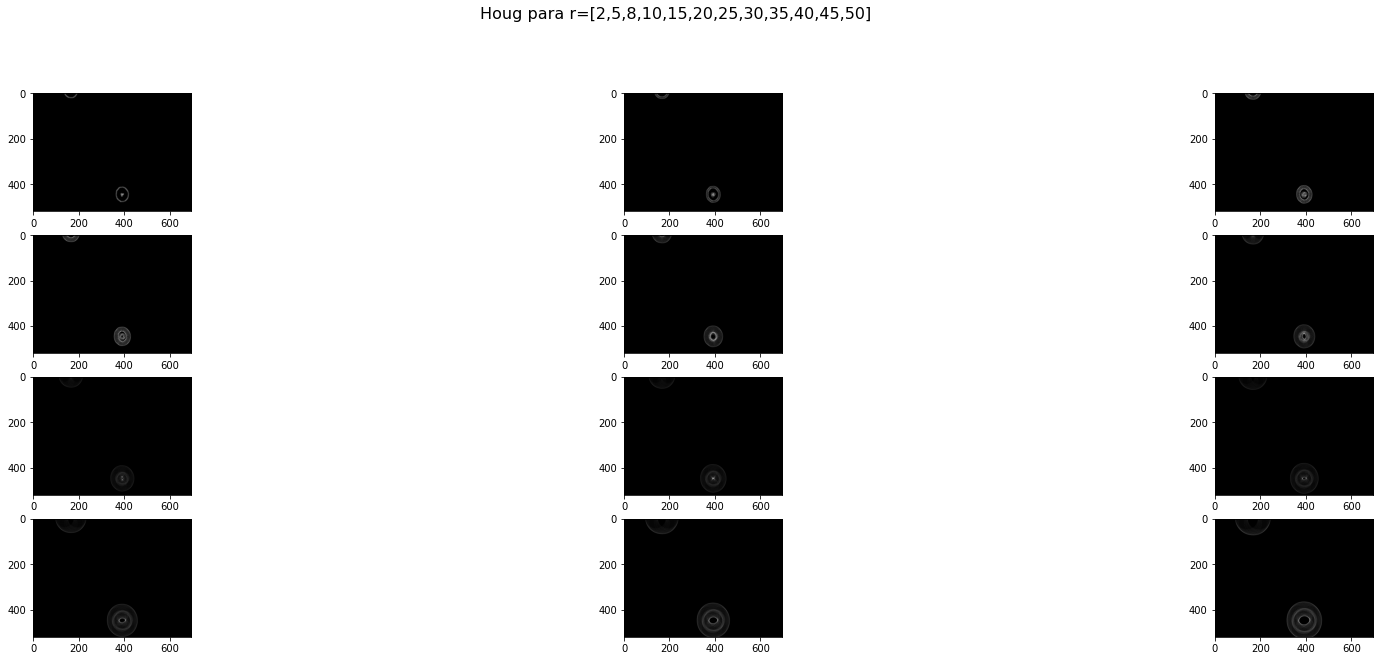

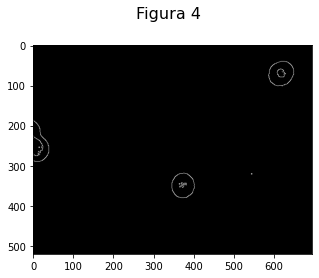

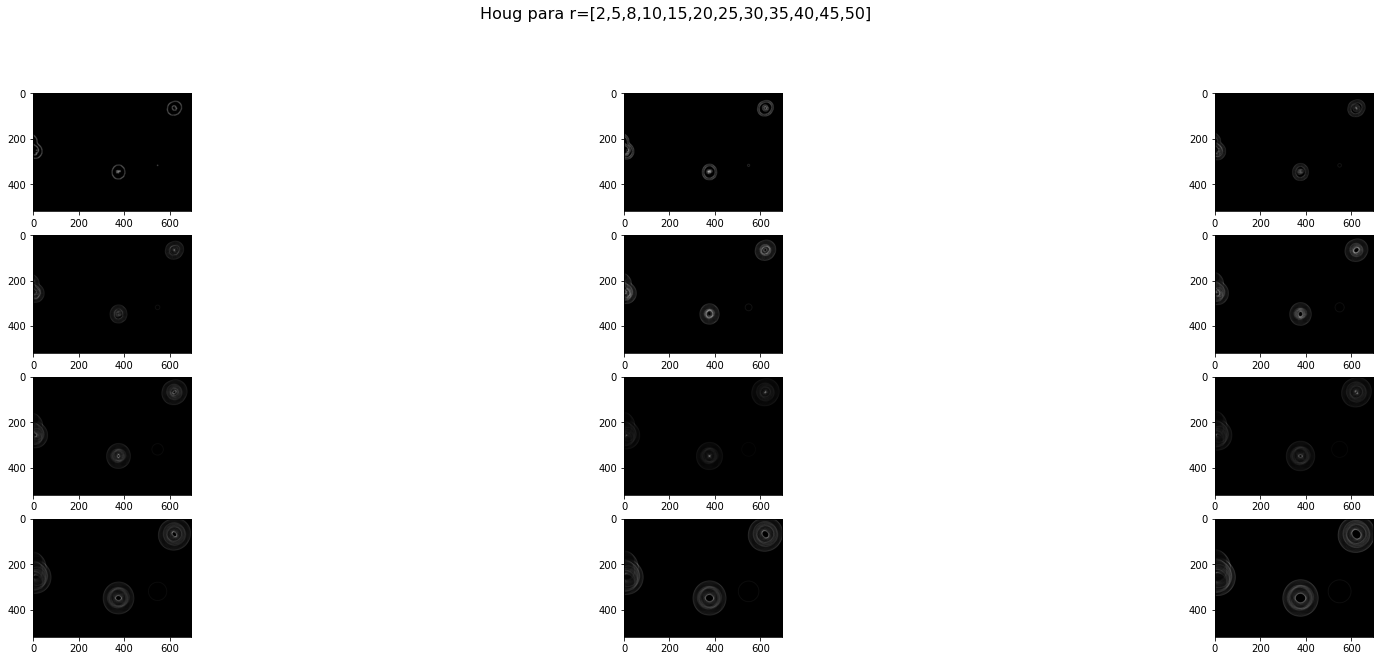

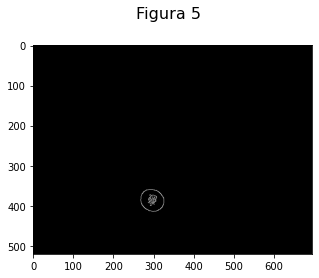

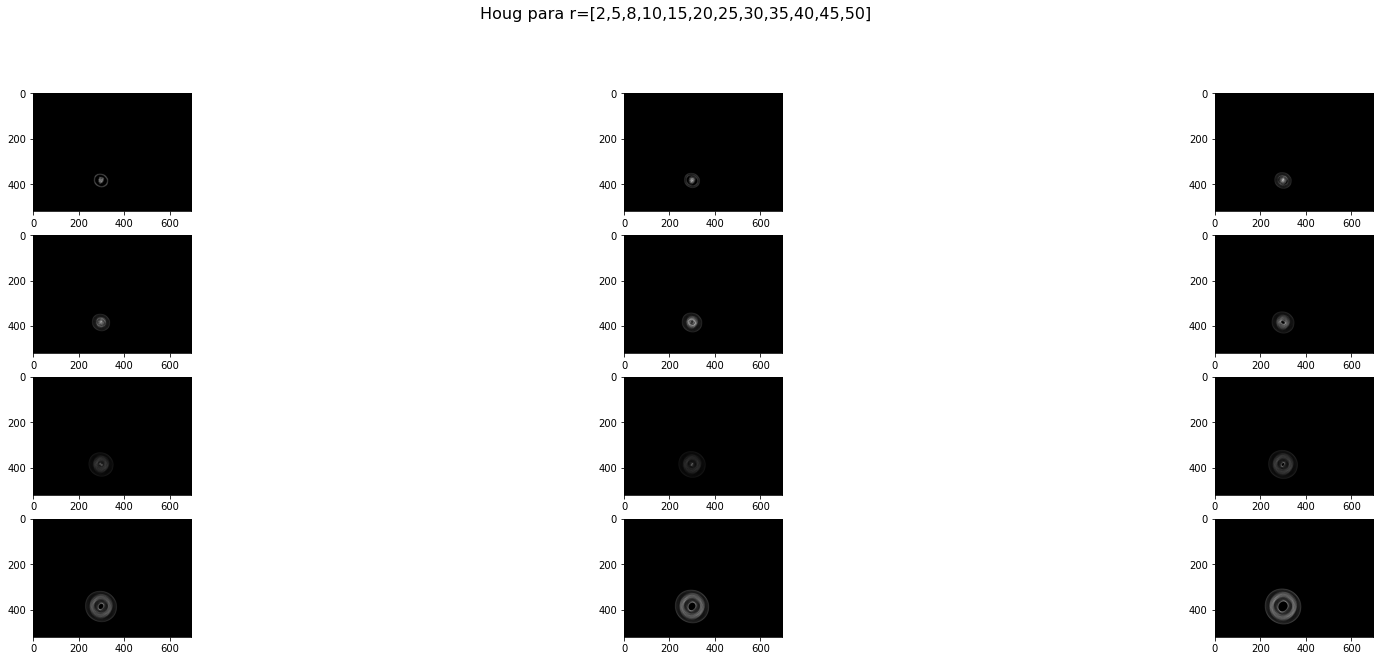

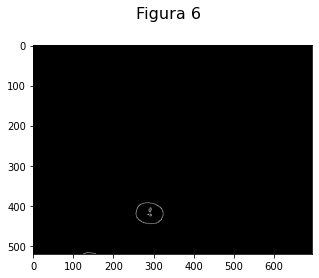

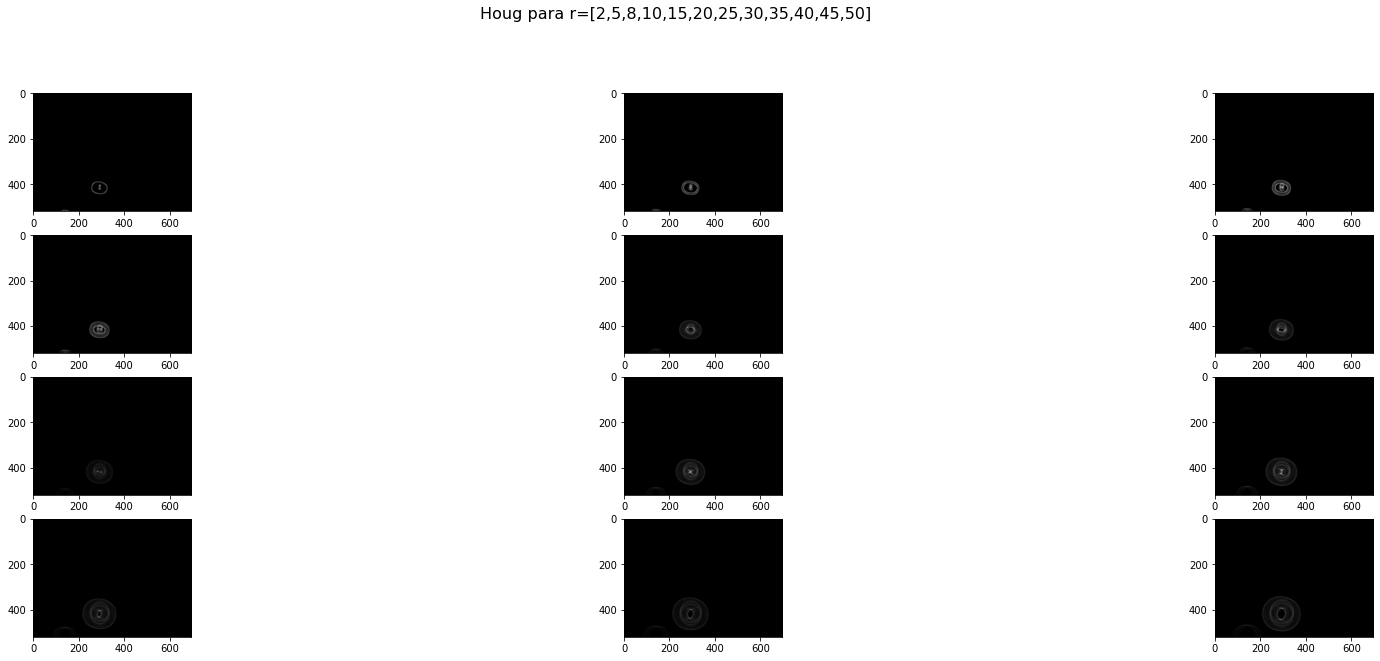

In [16]:
hough_imgs = []
for i,contour in enumerate(contours):
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle('Figura '+ str( i+1),  y=0.9, fontsize=16 )
    plt.imshow(contour, cmap='gray')

    fig = plt.figure(figsize=(30, 10))
    fig.suptitle('Hough para r=[2,5,8,10,15,20,25,30,35,40,45,50]',  y=1, fontsize=16 )
    himgs = []
    for j,r in enumerate([2,5,8,10,15,20,25,30,35,40,45,50]):
            c = hough_circle_transform( contour, radius=r )
            fig.add_subplot(4, 3, j+1)
            plt.imshow(c, cmap='gray')
            himgs += [c]
    hough_imgs += [himgs]

As características foram então salvas para poderem ser usadas novamente em outra ocasião.

In [ ]:
np.save('hough.npy', np.array( hough_imgs ))

In [6]:
hough_features = np.load('hough.npy').astype('uint8')

As caracteristicas foram então normalizados entre $0$ e $255$ para cada tamanho de raio..

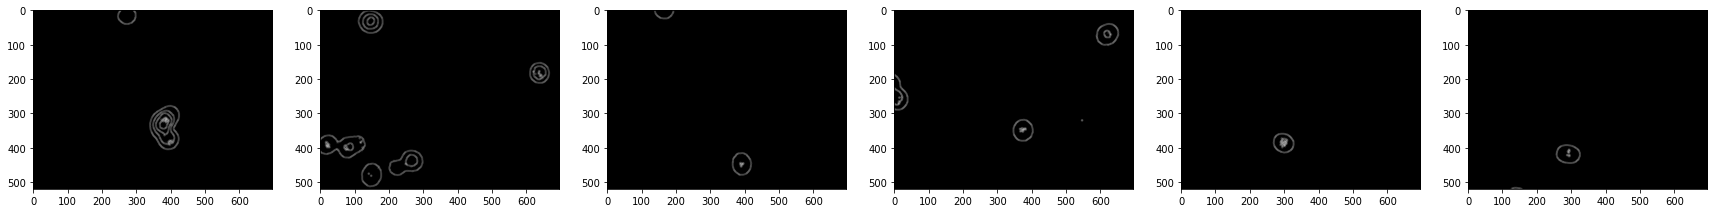

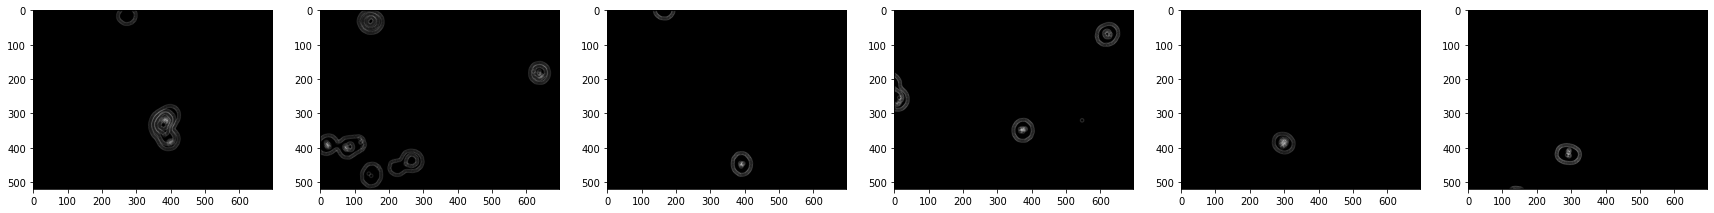

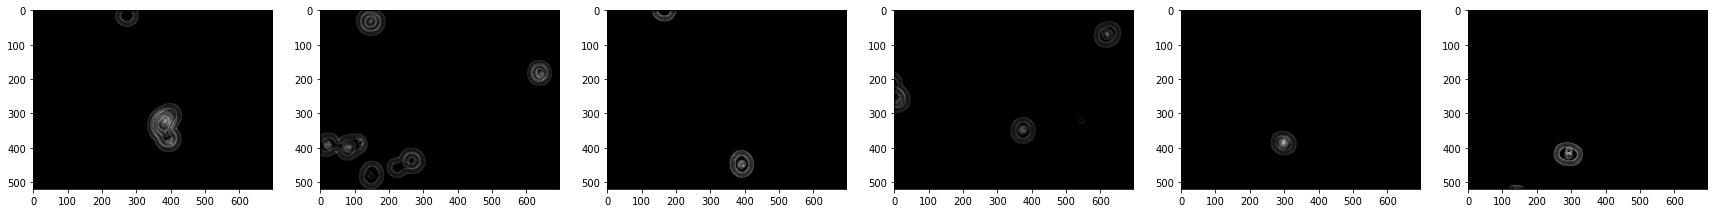

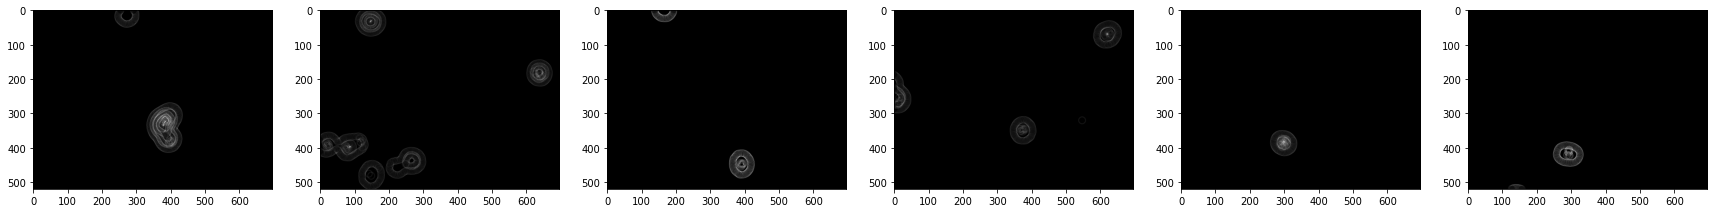

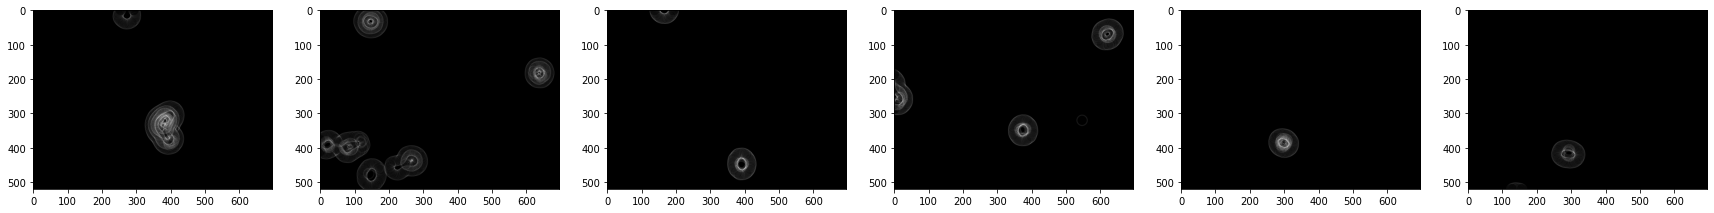

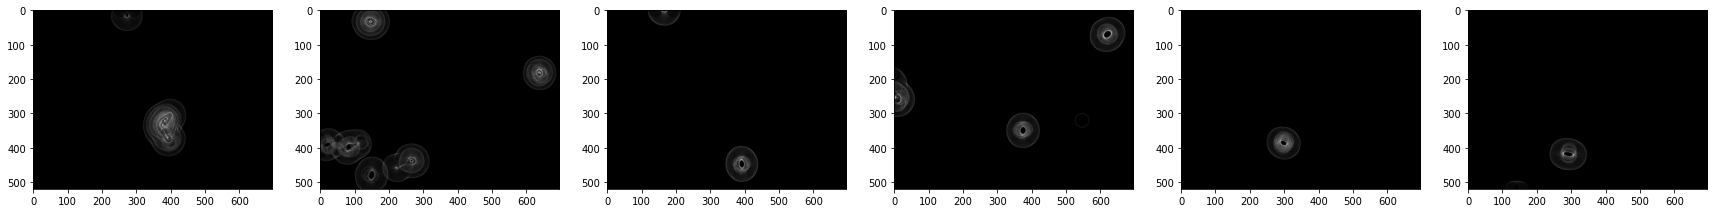

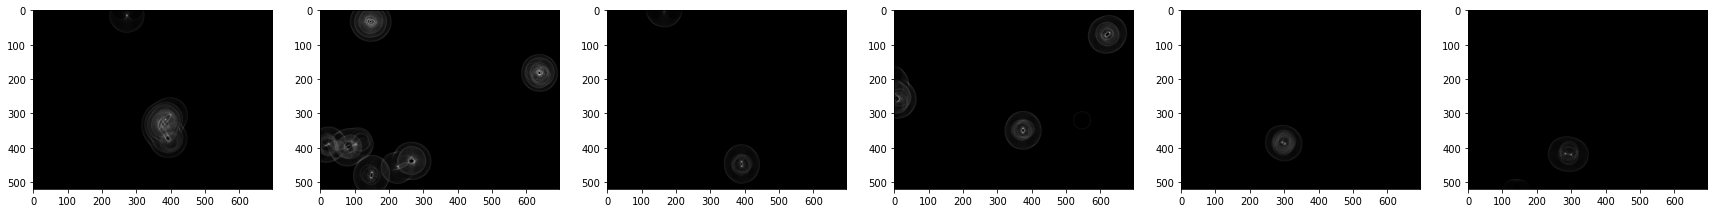

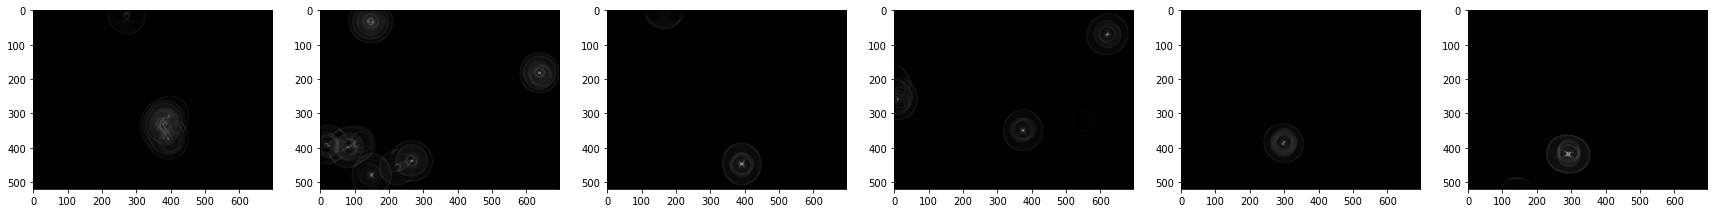

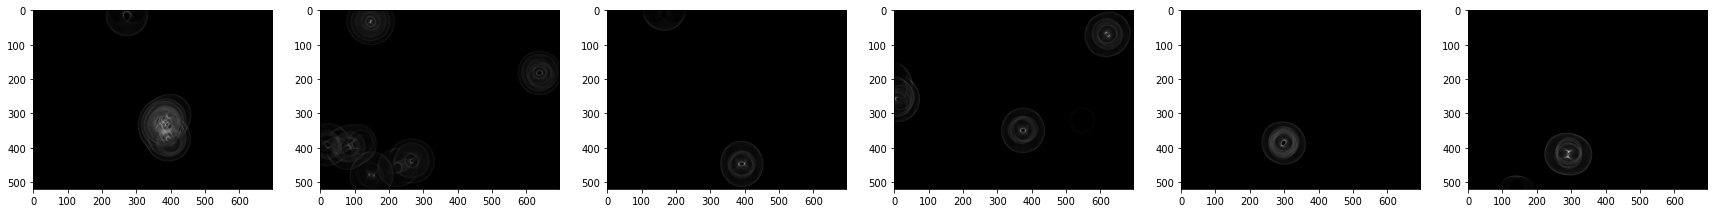

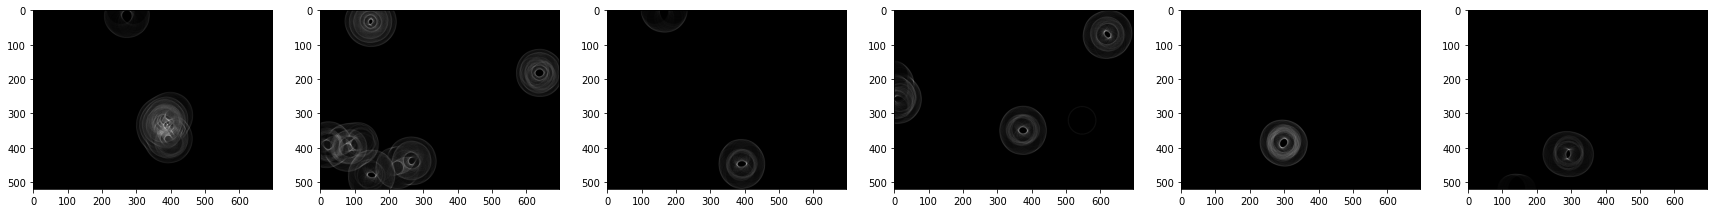

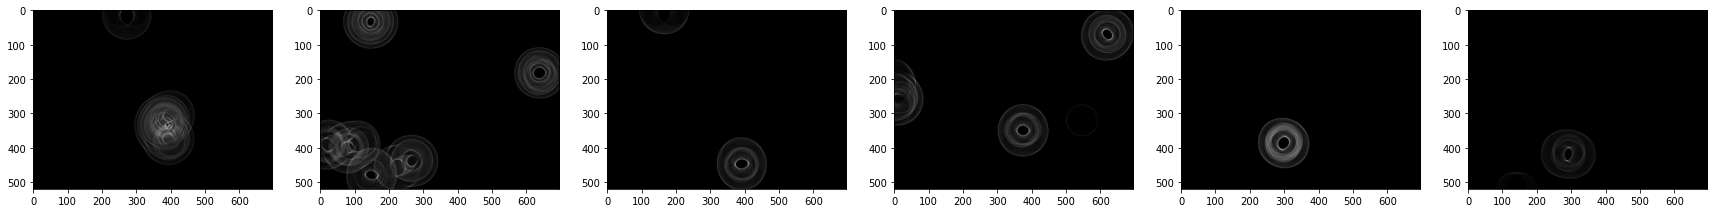

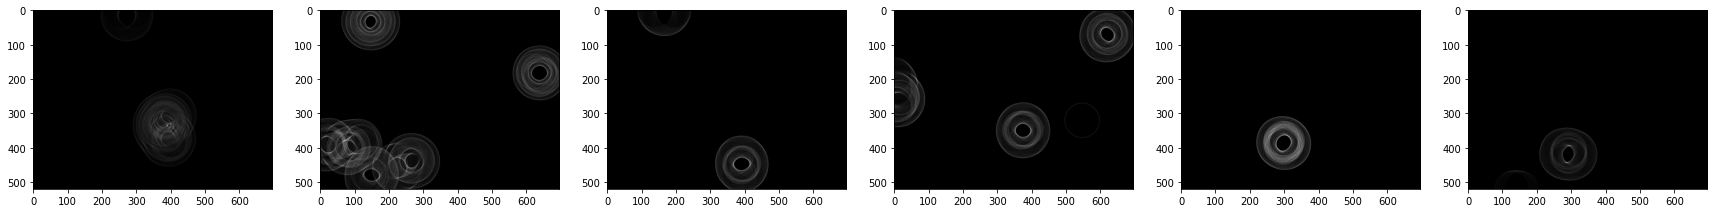

In [7]:
for j in range(12):
    fig = plt.figure(figsize=(30, 10))
    hough_features[:,j] = rescale(hough_features[:,j],0,255).astype('uint8')
    for i in range(6):
        fig.add_subplot(1, 6, i+1)
        plt.imshow(hough_features[i,j], cmap='gray')

Dado as características, para conseguir obter os centros dos circulos, é utilizada a função $find\_highest$ que escolhe os pontos no espaço $a \times b$ com intensidade maior que um limiar, um parametro $size$ é usado, que faz com quando há mais de um ponto a essa distância um do outro, apenas o de maior intensidade é guardado.

A função $highlight\_circles$ gera uma representação grafica, desemnhando um circulo para cada ponto, dado o seu centro e o seu raio.

In [8]:
def find_highest(img, threshold, size):
    shape = img.shape
    high_points = []
    highest_points = []
    high_img = np.zeros( img.shape )
    for i,j in np.argwhere( img ):
        if img[i,j] > threshold:
            high_img[i,j] = img[i,j]
            high_points += [[i,j]]
    
    for [i,j] in high_points:
        highest = True
        for x in range(-size[0],size[0]):
            for y in range(-size[1],size[1]):
                if valid_point(shape, x+i, y+j) and high_img[x+i, y+j]>high_img[i, j]:
                    highest = False
        if highest:
            highest_points += [[i,j]]
    return highest_points

def highlight_circles( centers, shape,radius, step=10):
    angles = np.arange( 0, 360, step = step  ) * np.pi / 180
    out = np.zeros( img.shape, dtype='uint')
    
    for i, [a,b] in enumerate(centers):
        for r in range(radius[i]):
            for theta in angles:
                x = int(a + np.round(r*np.cos(theta)))
                y = int(b + np.round(r*np.sin(theta)))
                if valid_point(shape, x, y):
                    out[x,y] = 1
    return out

As funções $find\_highest$ e $highlight\_circles$ são então usadas para destacar os circulos encontrados nas imagens de células para cada um dos valores de raio testados, sendo possível observar os resultados a seguir.
O valor de limiar utilizado foi de $70\%$ do valor máximo (que é 255 devido a normalização).

Como pode ser visto, diferentes valores de raio faram capazes de encontrar células de tamanhos diferentes, e nos casos dos raios menores, foi encontrado o núcleo da célula.

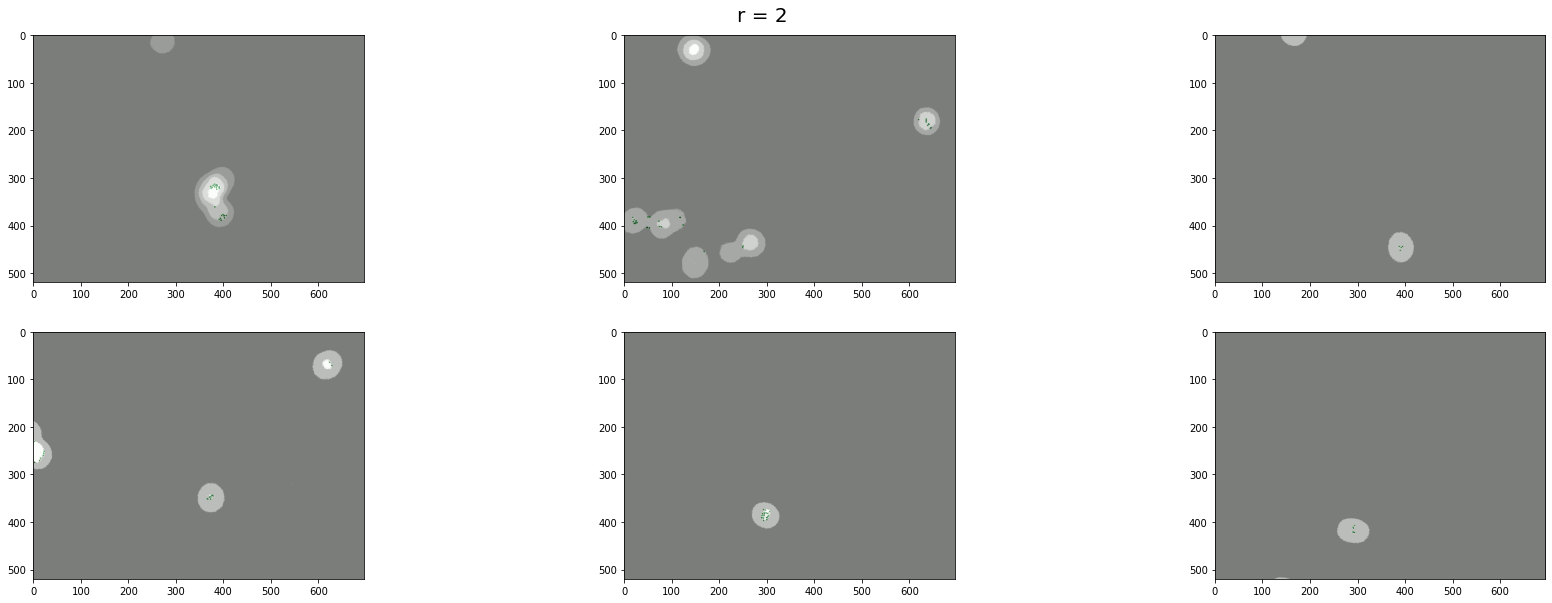

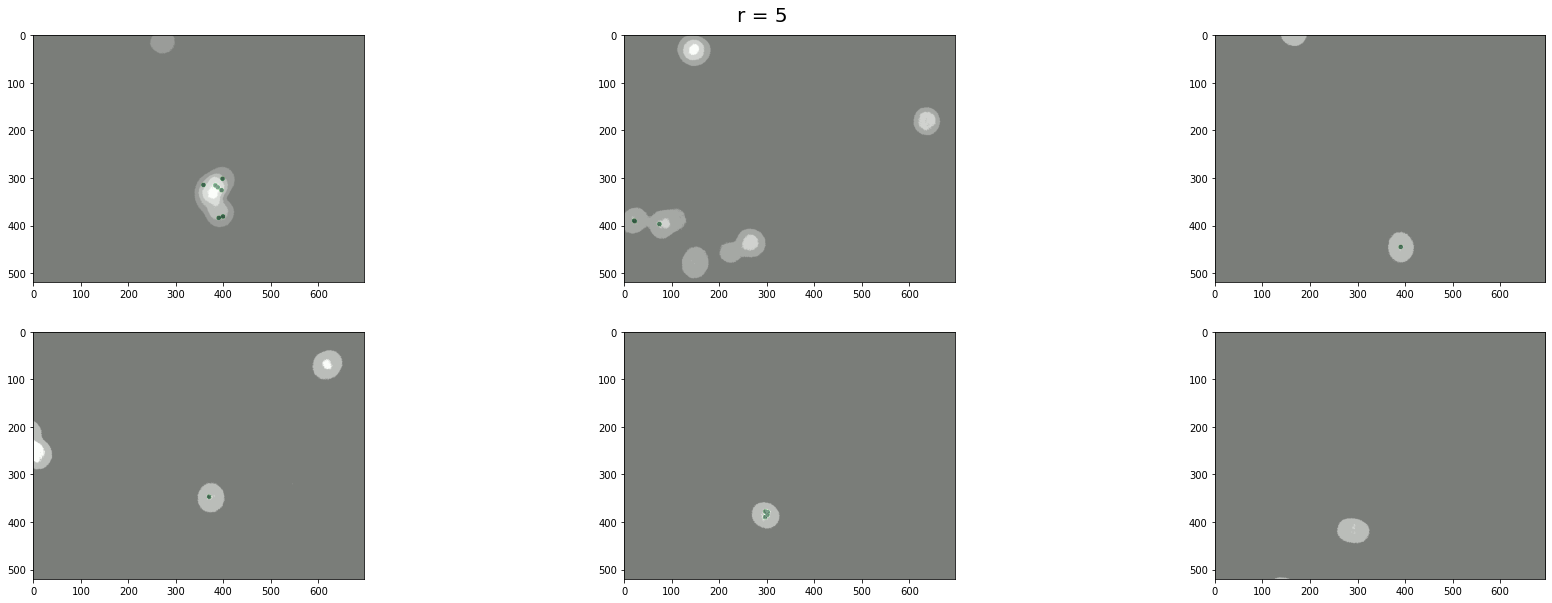

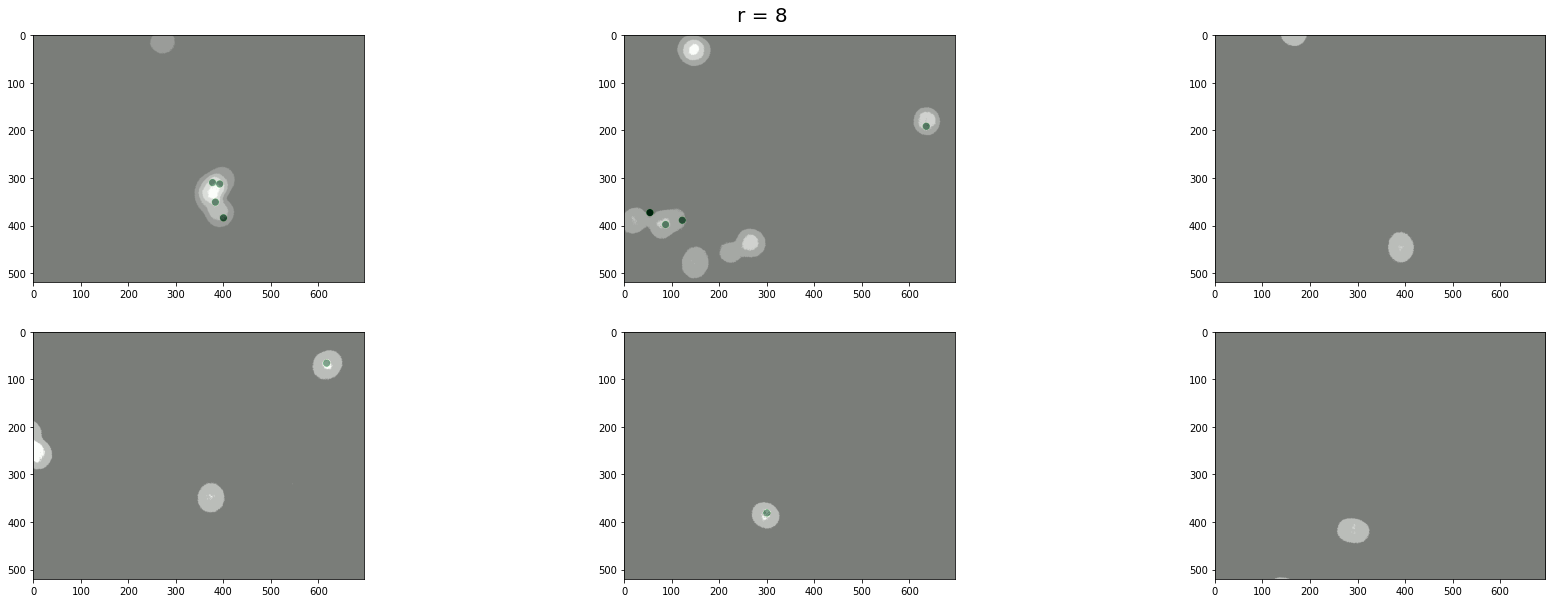

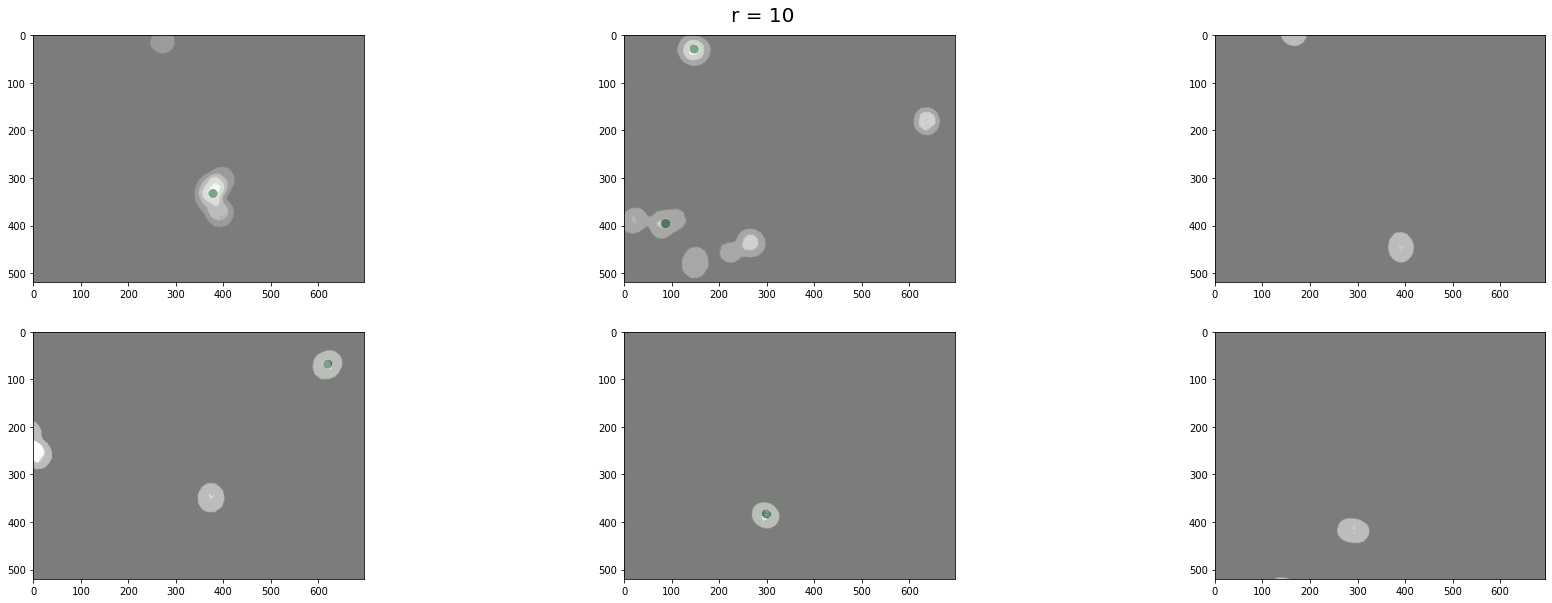

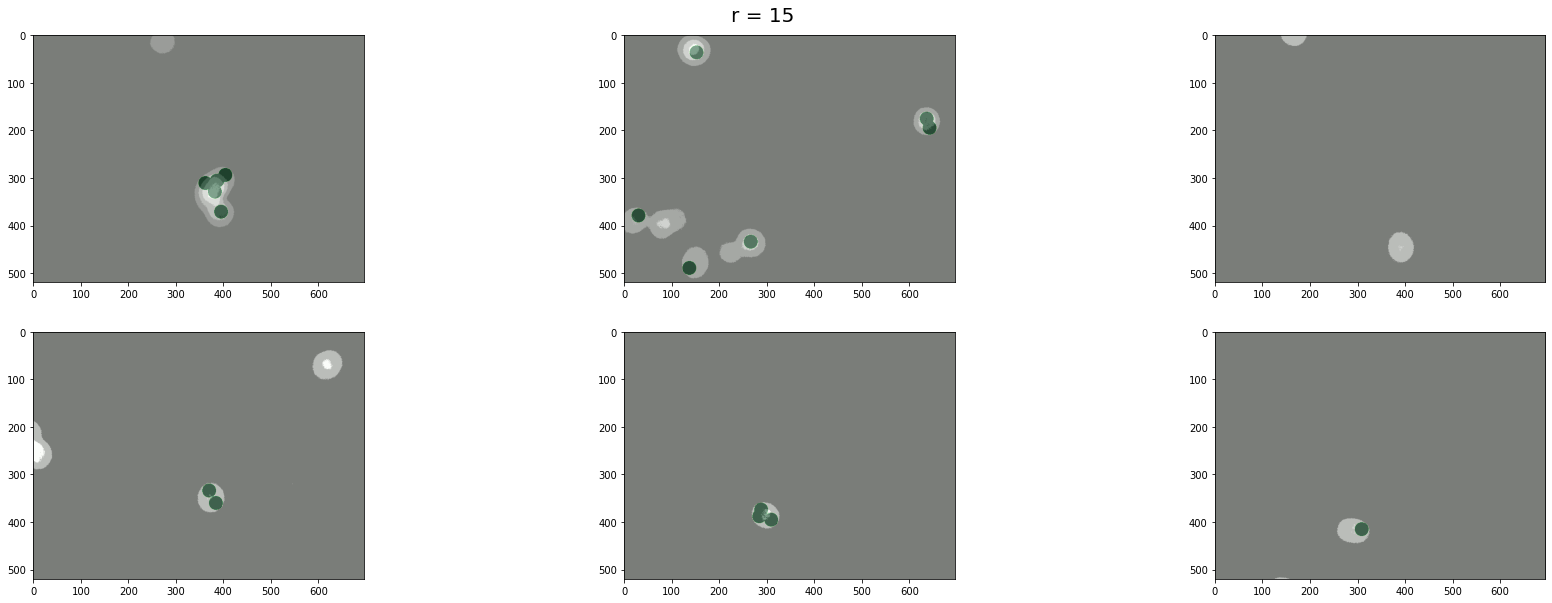

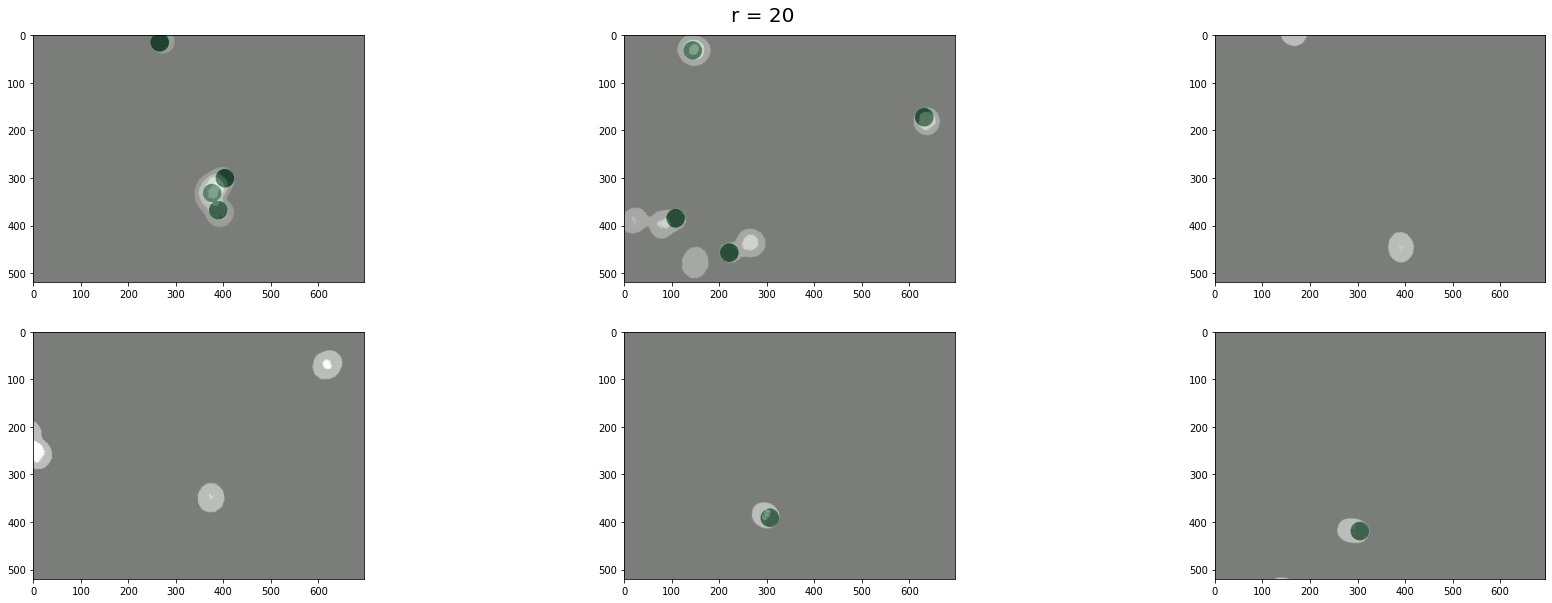

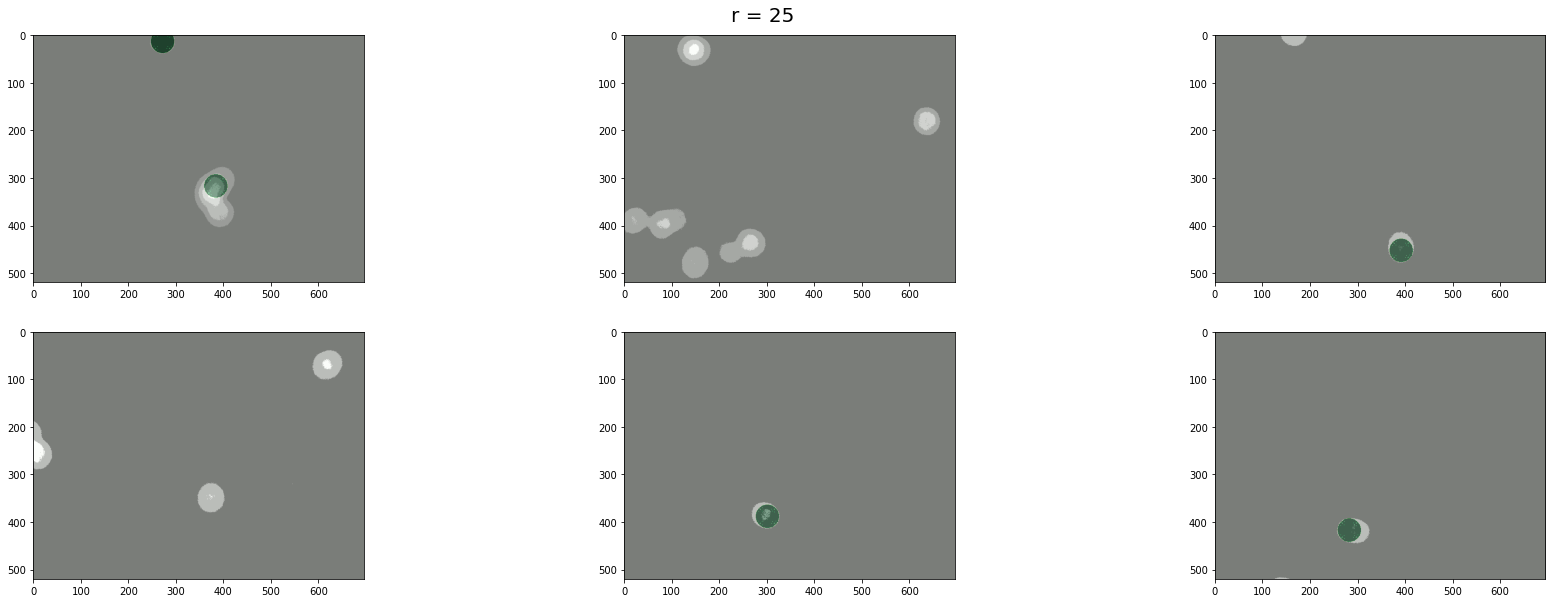

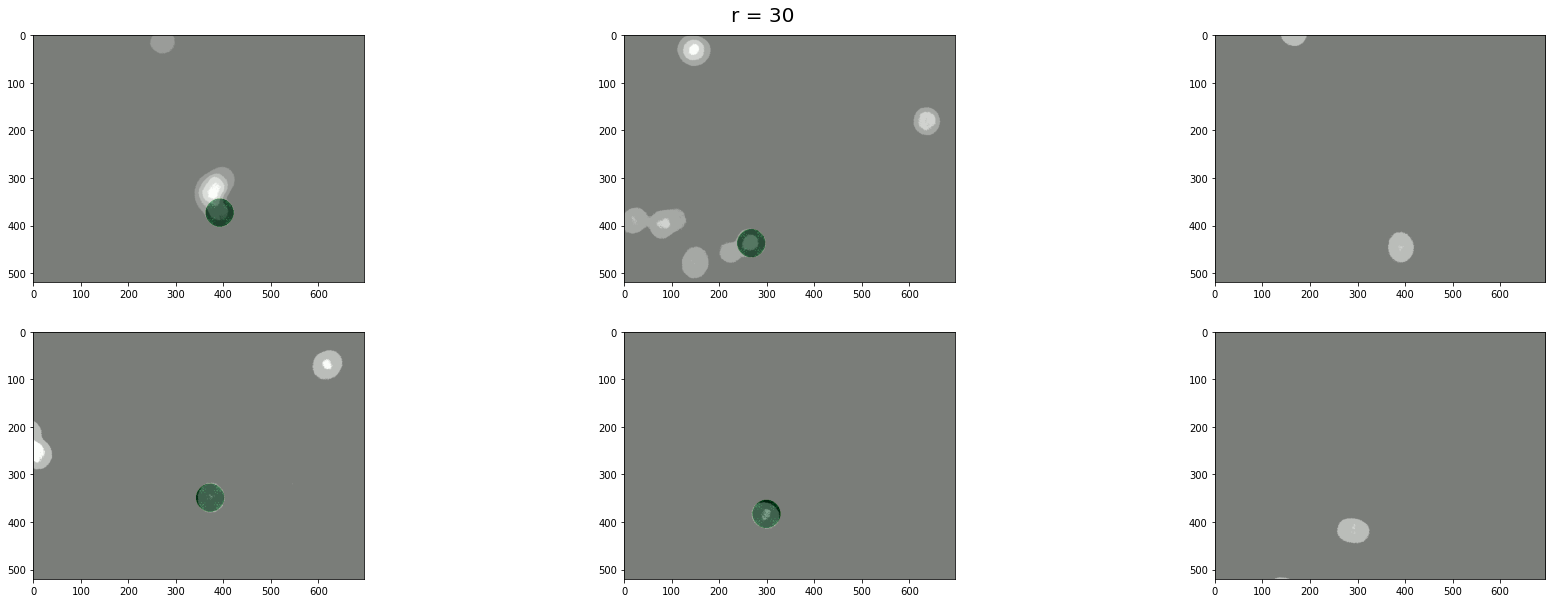

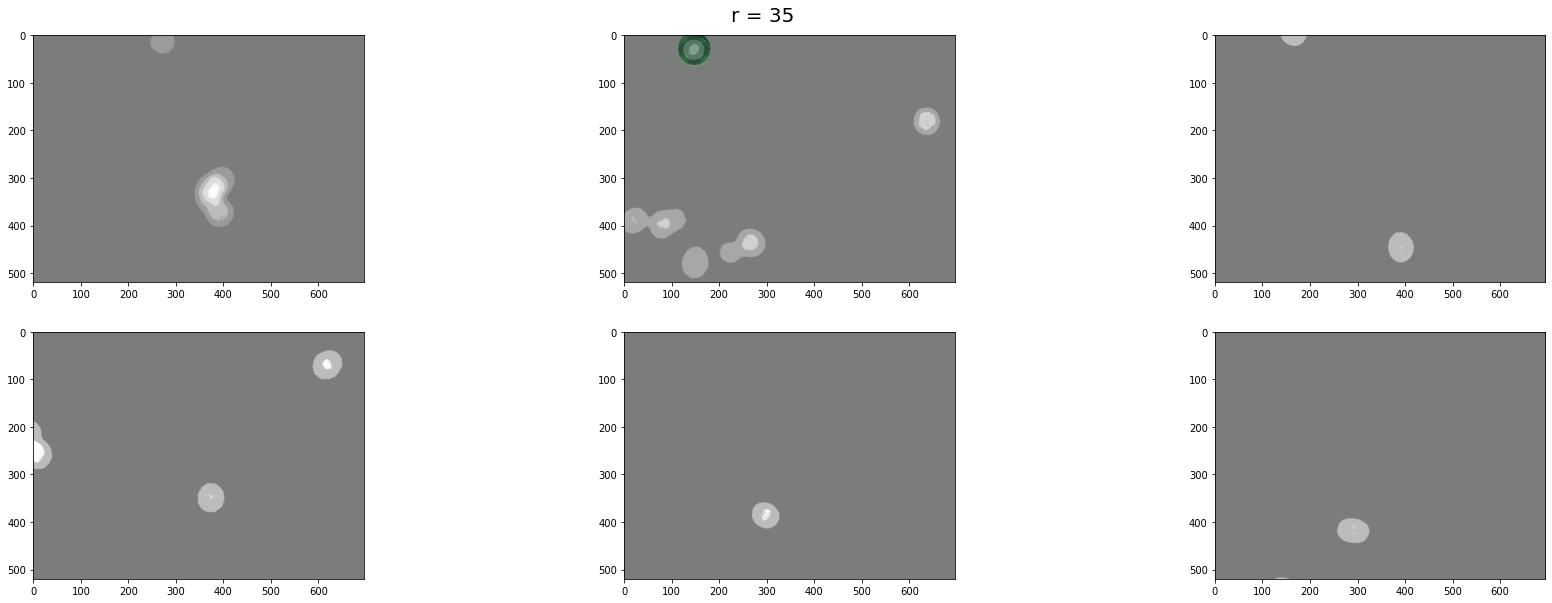

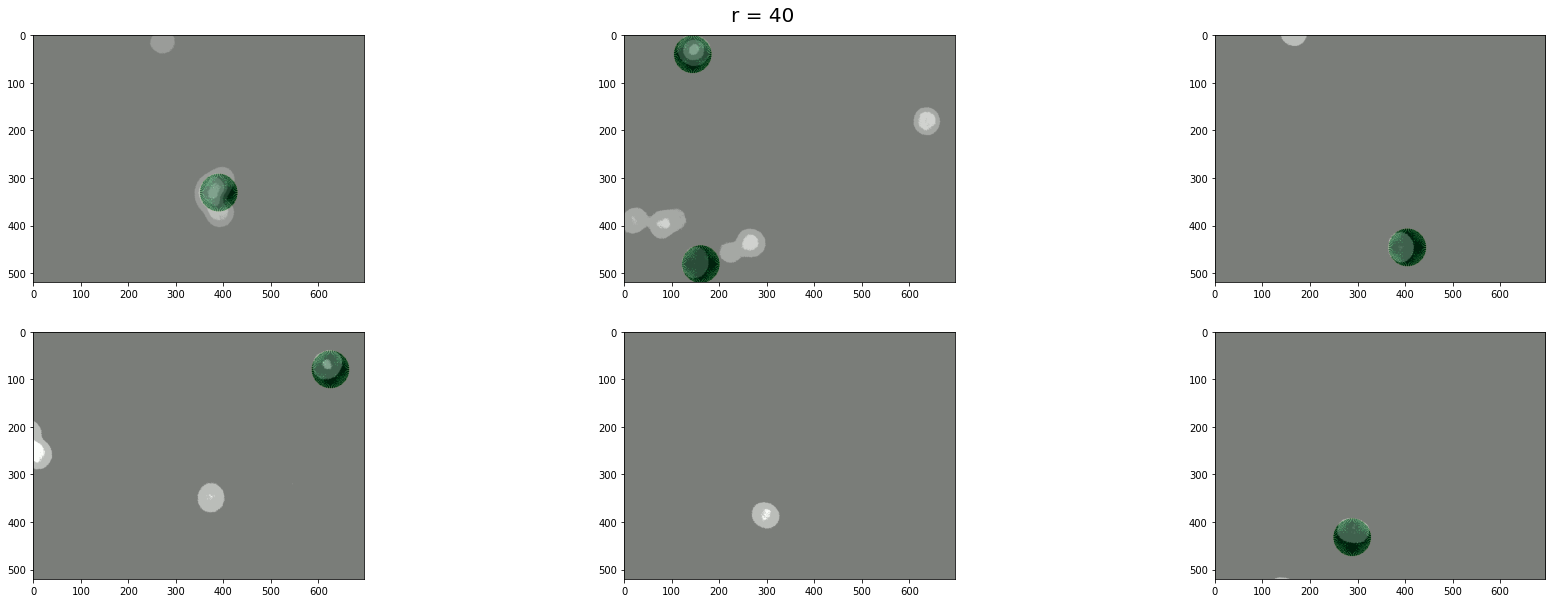

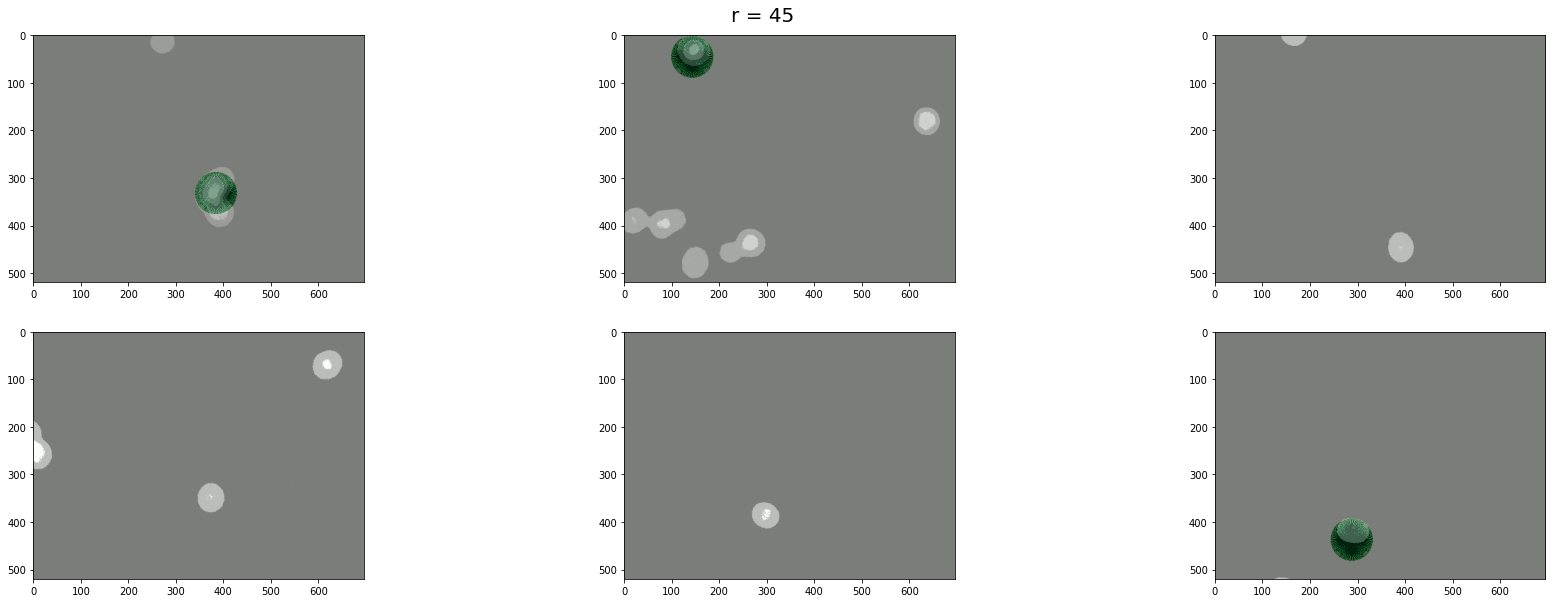

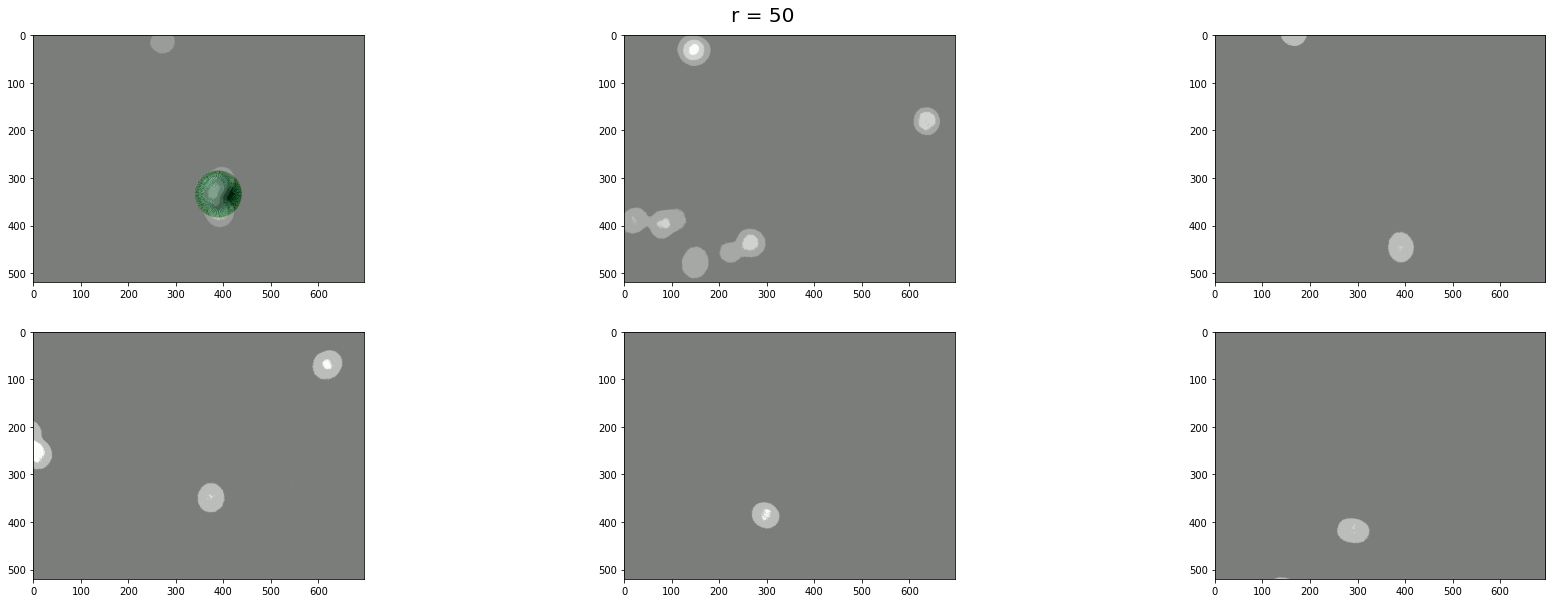

In [9]:
thresh = 0.7*hough_features.max( )
for j,r in enumerate([2,5,8,10,15,20,25,30,35,40,45,50]):
    fig = plt.figure(figsize=(30, 10))
    fig.suptitle('r = '+str(r), y=0.92, fontsize=20)

    for img_i in range(hough_features.shape[0]):
        points = find_highest(hough_features[img_i,j], thresh, [r,r] )
        radius = []
        for i in range(len(points)):
            radius += [r]
        h = highlight_circles(points, img.shape, radius, step=2)
        fig.add_subplot(2, 3, img_i+1)
        plt.imshow(imgs[img_i], cmap='gray')
        plt.imshow(h , cmap='Greens', vmin=0, vmax=1, alpha=0.5)

A função de $select\_points$ foi implementada para combinar pontos que representam centro de circulos de difrentes tamanhos de raio. Caso dois circulos esteja sobrepondo o centro de outro, o que tiver menor raio é removido.

In [10]:
def select_points(points, radius):
    high_points = []
    highest_points = []

    keep = np.ones( len(points) ,dtype='bool' )
    for k,[i,j] in enumerate(points):
        for l,[x,y] in enumerate(points):
            if k!=l and euclidean([i,j], [x,y]) < radius[k]:
                if radius[k] < radius[l]:
                    keep[k] = False
                else:
                    keep[l] = False
    
    out_points = []
    out_radius = []
    for i in range(len(keep)):
        if keep[i]:
            out_points += [points[i]]
            out_radius += [radius[i]] 
        
    return out_points, out_radius

A função $select\_points$ é usada então para combinar os resultados dos circulos detectados com raio de $20,25,30,35$ e $40$. Esses tamanhos foram usados pois com eles foi observado (nos resultados mostrados anteriormente) que células de diferentes tamanhos foram detectadas. 
O objetivo é encontrar as membranas das células.

A lista de pontos que representam o centro do circulo, seus raios e a representação gráfica é mostrada a seguir.

Como pode ser visto, foi possível detectar um grande número de células, no entanto, em alguns casos, o circulo encontrado é um pouco maior que a célula, a celula não tem um formato circular exato, ou é composta por multiplos circulos, ou o circulo encontrado é um pouco menor que a célula.

Imagem 0 :
 Pontos: [[15, 272], [374, 392], [332, 390]] 
Raios: [25, 30, 40] 

Imagem 1 :
 Pontos: [[174, 631], [386, 108], [458, 221], [438, 267], [42, 144], [482, 161]] 
Raios: [20, 20, 20, 30, 40, 40] 

Imagem 2 :
 Pontos: [[447, 404]] 
Raios: [40] 

Imagem 3 :
 Pontos: [[349, 372], [80, 625]] 
Raios: [30, 40] 

Imagem 4 :
 Pontos: [[383, 299]] 
Raios: [30] 

Imagem 5 :
 Pontos: [[432, 288]] 
Raios: [40] 



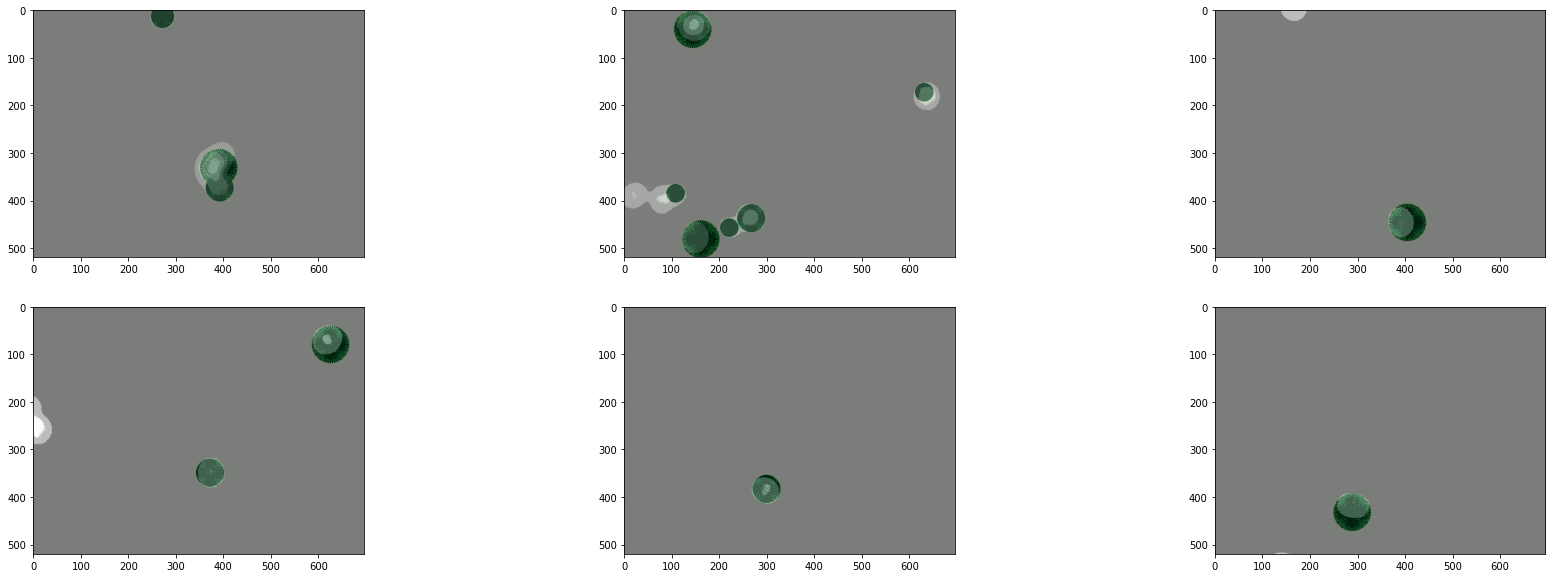

In [12]:
thresh = hough_features.max( ) * np.array([0.7,0.7, 0.7, 0.7, 0.7])
fig = plt.figure(figsize=(30, 10))

membrana_points = []
membrana_radius = []


for img_i in range(hough_features.shape[0]):
    points_img = []
    radius_img = []
    
    fig.add_subplot(2, 3, img_i+1)
    plt.imshow(imgs[img_i], cmap='gray')
    h = np.zeros(imgs[img_i].shape)
    
    for j,r in enumerate([20,25,30,35,40]):         
        points = find_highest(hough_features[img_i,j+5], thresh[j], [r,r] )
        points_img += points
        
        for i in range(len(points)):
            radius_img += [ r ]
    m_points, m_radius = select_points(points_img, radius_img)
    
    print('Imagem', img_i,':\n', 'Pontos:', m_points, '\nRaios:', m_radius,'\n')
    
    h += highlight_circles(m_points, img.shape, m_radius, step=2)
    plt.imshow(h , cmap='Greens', vmin=0, vmax=1, alpha=0.5)
    
    membrana_points += [m_points]
    membrana_radius += [m_radius]
    

A proxima tarefa abordada foi tentar encontrar os núcleos dentro dessas células. Para isso, foi implementada a função $select\_points\_inside$, que dado uma lista de pontos e raios das membranas e dos núcleos, tenta, para cada membrana, selecionar um núcleo adequado.

Procura-se por núcleos que estejam proximos ao centro do circulo da membrana, sendo dada preferência a circulos maiores. Quanto mais alto o parâmetro $ratio$, mais preferência e dada a núcleos proximos do centro da membrana. 

In [13]:
def select_points_inside(points_inside, radius_inside, points, radius, ratio=0.7):
    high_points = []
    highest_points = []

    keep = np.zeros( len(points_inside) ,dtype='bool' )
    for k,[i,j] in enumerate(points):
        closer = None
        closer_radius = 0
        for l,[x,y] in enumerate(points_inside):
            dist = euclidean([i,j], [x,y])
            if dist <= ratio*radius[k]-radius_inside[l]:
                #if dist < closer_dist:
                if radius_inside[l] > closer_radius:
                    closer_radius = radius_inside[l]
                    closer = l
        
        if closer is not None:
            keep[closer] = True
    
    out_points = []
    out_radius = []
    for i in range(len(keep)):
        if keep[i]:
            out_points += [points_inside[i]]
            out_radius += [radius_inside[i]] 
        
    return out_points, out_radius

Abaixo, são detectados os possíveis circulos que representam o núcleo das células, sendo usado a função $select\_points\_inside$ para escolher os que estão dentro dos criculos das membranas.

Foram usados os raios de $2,5,8,10$ e $15$ para detectar os núcleos, observando os resultados anteriores.

A seguir é mostrado os pontos do centro de cada circulo de núcleo encontrado, o seu raio e uma representação gráfica, onde o núcleo é destacado de vermelho e a membrana de verde.

Como pode ser visto, em algumas células, foi possível destacar exatamente onde o núcleo da célula esta, no entanto em outras, o núcleo não foi encontrado por completo. Alguns possíveis motivos para isso são a forma irregular de alguns núcleos e a detecção da membrana, que não ficou exatamente no centro em alguns casos, prejudicando a etapa seguinted e detecção de núcleo.

Imagem 0 :
 Pontos: [[330, 382], [372, 395]] 
Raios: [15, 15] 

Imagem 1 :
 Pontos: [[178, 635], [384, 117], [38, 152], [435, 266]] 
Raios: [2, 2, 15, 15] 

Imagem 2 :
 Pontos: [[446, 390]] 
Raios: [5] 

Imagem 3 :
 Pontos: [[347, 370], [69, 619]] 
Raios: [5, 10] 

Imagem 4 :
 Pontos: [[383, 299]] 
Raios: [10] 

Imagem 5 :
 Pontos: [[407, 293]] 
Raios: [2] 



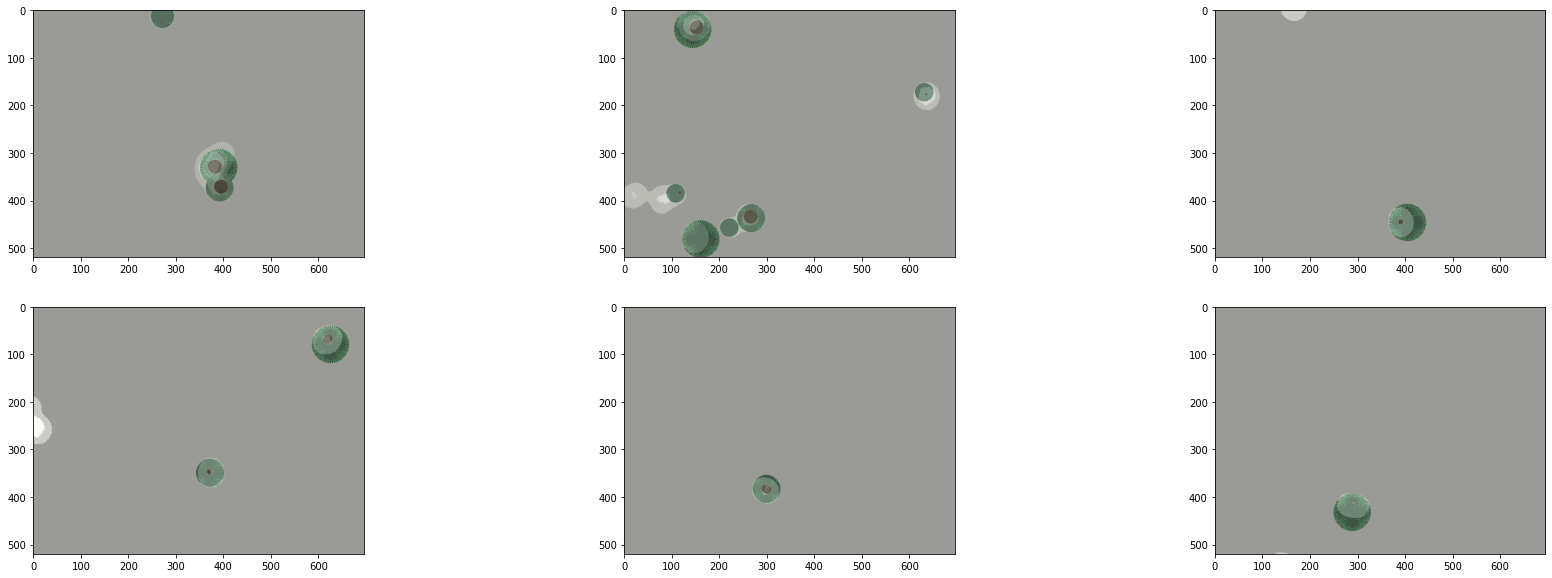

In [14]:
thresh = hough_features.max( ) * np.array([0.7,0.7, 0.7, 0.7, 0.7])
fig = plt.figure(figsize=(30, 10))

nucleo_points = []
nucleo_radius = []

for img_i in range(hough_features.shape[0]):
    points_img = []
    radius_img = []
    
    fig.add_subplot(2, 3, img_i+1)
    plt.imshow(imgs[img_i], cmap='gray')
    
    for j,r in enumerate([2,5,8,10,15]):         
        points = find_highest(hough_features[img_i,j], thresh[j], [r,r] )
        points_img += points
        
        for i in range(len(points)):
            radius_img += [ r ]
    n_points, n_radius = select_points_inside(points_img, radius_img,
                                            membrana_points[img_i], membrana_radius[img_i])
    
    print('Imagem', img_i,':\n', 'Pontos:', n_points, '\nRaios:', n_radius,'\n')
    
    m = highlight_circles(membrana_points[img_i], img.shape, membrana_radius[img_i], step=2) 
    plt.imshow(m , cmap='Greens', vmin=0, vmax=1, alpha=0.5)
    
    n = highlight_circles(n_points, img.shape, n_radius, step=2) 
    plt.imshow(n , cmap='Reds', vmin=0, vmax=1, alpha=0.25)
    
    nucleo_points += [n_points]
    nucleo_radius += [n_radius]
    